In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

def add_to_path(src_dir):
    if src_dir not in sys.path:
        sys.path.insert(0, src_dir)

add_to_path('code')

In [152]:
import json
import pickle

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch

from easydict import EasyDict as edict

from mac import MACNetwork
from utils import IntermediateLayerGetter, load_vocab
from datasets import GQADataset, collate_fn_gqa, ClevrDataset, collate_fn, collate_fn_gqa_objs
from visualize_attentions import plot_vqa_attn
from visualize_attentions import plot_word_img_attn_lobs, plot_word_img_attn_objs, idxs_to_question, get_image

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.empty(1, device=DEVICE)
print(DEVICE)

cuda


In [14]:
model_dir = 'data/clevr_uni_gtlobs1/'

with open(os.path.join(model_dir, 'cfg.json'), 'r') as f:
    cfg = json.load(f)

In [15]:
cfg

{'GPU_ID': '0',
 'CUDA': True,
 'WORKERS': 1,
 'LOGDIR': 'clevr_uni_gtlobs1',
 'COMET_PROJECT_NAME': 'clevr-uniform',
 'EVAL': '',
 'TEST': False,
 'TEST_BATCH_SIZE': 128,
 'SAMPLE': False,
 'resume_model': None,
 'resume_model_ema': None,
 'start_epoch': None,
 'TRAIN': {'FLAG': True,
  'LEARNING_RATE': 0.0001,
  'BATCH_SIZE': 64,
  'MAX_EPOCHS': 50,
  'SNAPSHOT_INTERVAL': 5,
  'WEIGHT_INIT': 'xavier_uniform',
  'CLIP_GRADS': True,
  'CLIP': 8,
  'EALRY_STOPPING': True,
  'PATIENCE': 5,
  'VAR_DROPOUT': False,
  'RADAM': False},
 'DATASET': {'DATASET': 'clevr',
  'DATA_DIR': '/storage1/datasets/CLEVR_Uni_v1.0/data',
  'COGENT': '',
  'train_split': 'train',
  'params': {'feats_fname': '',
   'info_fname': '',
   'spatial_feats_dset_name': 'data',
   'objects_feats_dset_name': 'features',
   'objects_bboxes_dset_name': 'bboxes',
   'sample_size': 100}},
 'model': {'init_mem': 'random',
  'max_step': 4,
  'separate_syntax_semantics': False,
  'use_feats': 'spatial',
  'num_gt_lobs': 1,


In [17]:
from config import __C, _merge_a_into_b

cfg = edict(cfg)

In [193]:
dataset = cfg.DATASET.DATASET
uniform = False

if dataset == 'clevr':
    # dataset_root = '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/'
    if uniform:
        dataset_root = '/storage1/datasets/CLEVR_Uni_v1.0/'
        data_dir = os.path.join(dataset_root, 'data')    
    else:
        dataset_root = '/storage1/datasets/CLEVR_v1.0/'
        data_dir = os.path.join(dataset_root, 'features')
    images_dir = os.path.join(dataset_root, 'images')
elif dataset == 'gqa':
    # dataset_root = '/Users/sebamenabar/Documents/datasets/GQA/'
    dataset_root = '/storage1/datasets/GQA/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
    
cfg.DATASET.DATA_DIR = data_dir
# cfg.CUDA = False
# cfg.GPU_ID = '-1'

split = 'val'
if cfg.DATASET.DATASET == 'gqa':
    ds = GQADataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
        use_feats=use_feats,
        **cfg.DATASET.params,
    )
    with open(os.path.join(data_dir, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
elif cfg.DATASET.DATASET == 'clevr':
    if uniform:
        spatial_feats_dset_name = 'data'
        questions_fname = f'CLEVR_uni_{split}_questions.json'
    else:
        spatial_feats_dset_name = 'data'
        questions_fname = f'CLEVR_{split}_questions.json'
    ds = ClevrDataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
        spatial_feats_dset_name=spatial_feats_dset_name,
    )
    with open(os.path.join(dataset_root, 'questions', questions_fname), 'r') as f:
        ds.questions = json.load(f)['questions']

In [18]:
vocab = load_vocab(cfg)
reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']
num_answers = len(reverse_answer_dic)

model = MACNetwork(cfg, vocab, num_answers=num_answers).to(DEVICE)
state = torch.load(os.path.join(model_dir, 'Model', 'model_checkpoint_000020.pth'))
print(model.load_state_dict(state['model'], strict=False))
model.eval()

<All keys matched successfully>


MACNetwork(
  (input_unit): InputUnit(
    (stem): Sequential(
      (0): Dropout(p=0.18, inplace=False)
      (1): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.18, inplace=False)
      (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ELU(alpha=1.0)
    )
    (encoder): LSTM(300, 256, batch_first=True, bidirectional=True)
    (encoder_embed): Embedding(90, 300)
    (embedding_dropout): Dropout(p=0.15, inplace=False)
    (question_dropout): Dropout(p=0.08, inplace=False)
  )
  (output_unit): OutputUnit(
    (question_proj): Linear(in_features=512, out_features=512, bias=True)
    (classifier): Sequential(
      (0): Dropout(p=0.15, inplace=False)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.15, inplace=False)
      (4): Linear(in_features=512, out_features=28, bias=True)
    )
  )
  (mac): MACUnit(
    (control):

In [29]:
num_steps = cfg.model.max_step
num_lobs = cfg.model.read_unit.num_lobs
num_gt_lobs = cfg.model.read_unit.num_gt_lobs
read_gate = cfg.model.read_unit.gate
use_feats = cfg.model.use_feats

return_layers = {
    'mac.control.cw_attn_idty': 'cw_attn',
    'mac.read.kb_attn_idty': 'kb_attn',
    # 'mac.read.gate_sigmoid': 'read_gate',
    # 'mac.read.lobs_attn_idty': 'lobs_attn',
}
if read_gate:
    return_layers['mac.read.gate_sigmoid'] = 'read_gate'
if num_lobs > 0:
    return_layers['mac.read.lobs_attn_idty'] = 'lobs_attn'  

mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

In [33]:
ds[q_index]

(tensor([[[0.0000, 0.0702, 0.0000,  ..., 0.0000, 0.1095, 0.0491],
          [0.0813, 0.8692, 0.3312,  ..., 0.0277, 0.0393, 0.0000],
          [0.0000, 0.1043, 0.0000,  ..., 0.0000, 0.0083, 0.0000],
          ...,
          [0.0000, 0.3408, 0.0000,  ..., 0.0000, 0.0704, 0.0829],
          [0.0000, 0.1667, 0.0000,  ..., 0.0000, 0.1531, 0.0134],
          [0.0000, 0.1674, 0.0000,  ..., 0.0131, 0.0243, 0.0340]],
 
         [[0.1194, 0.0305, 0.0368,  ..., 0.0524, 0.0000, 0.0000],
          [0.3355, 0.8698, 0.6584,  ..., 0.7349, 0.0000, 0.0000],
          [0.0606, 0.0898, 0.0000,  ..., 0.0470, 0.0737, 0.0528],
          ...,
          [0.0901, 0.0636, 0.0405,  ..., 0.0940, 0.1313, 0.0863],
          [0.1170, 0.1526, 0.0000,  ..., 0.0726, 0.3159, 0.1147],
          [0.1880, 0.2849, 0.1621,  ..., 0.0717, 0.1302, 0.0393]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1481, 0.0000,  ...,

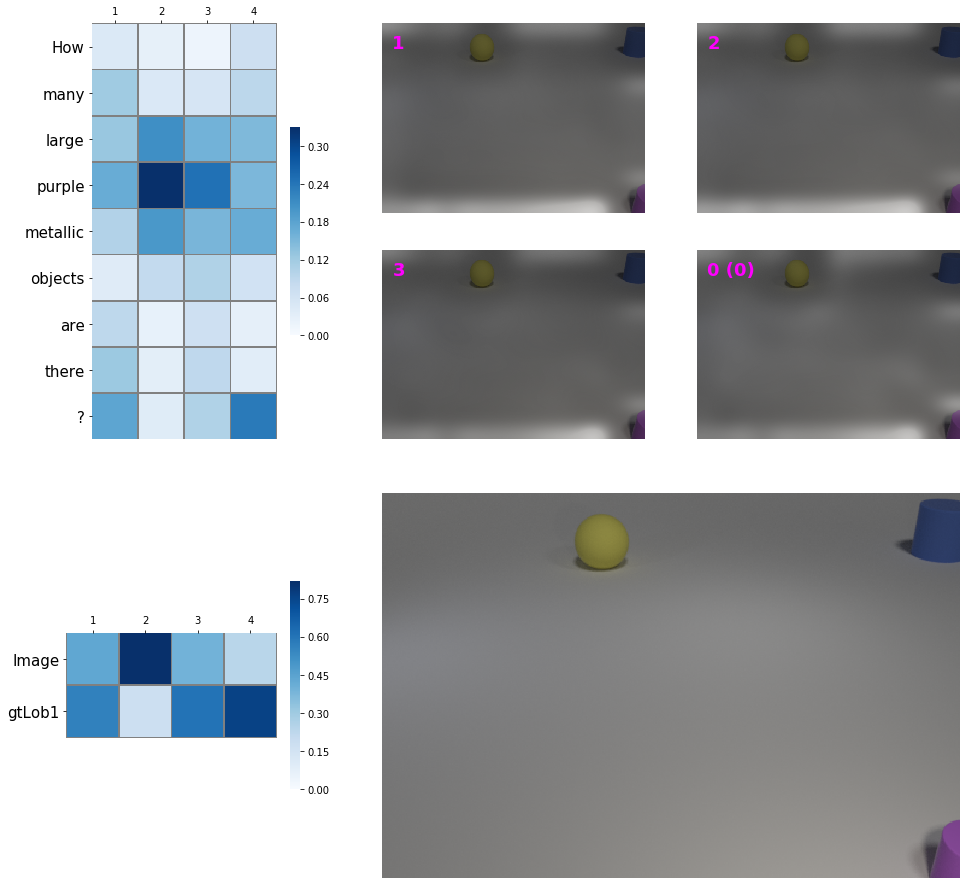

In [166]:
q_index = 0

if dataset == 'gqa':
    if use_feats == 'spatial':
        gqa_collate_fn = collate_fn_gqa
    elif use_feats == 'objects':
        gqa_collate_fn = collate_fn_gqa_objs
    b = gqa_collate_fn([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])

if type(b['image']) is tuple:
    b['image'] = tuple(v.to(DEVICE) for v in b['image'])
else:
    b['image'] = b['image'].to(DEVICE)
b['question'] = b['question'].to(DEVICE)

with torch.no_grad():
    mid_outputs, output = mid_getter(b['image'], b['question'].to(DEVICE), b['question_length'],)

kb_attn = torch.stack(mid_outputs['kb_attn']).squeeze(1).detach().cpu().numpy()
plot_kwargs = dict(
    img_fp=os.path.join(images_dir, image_filename),
    num_steps=num_steps,
    
    words=idxs_to_question(b['question'][0].detach().cpu().numpy(), vocab['question_idx_to_token']),
    words_attn=torch.stack(mid_outputs['cw_attn']).squeeze().detach().cpu().numpy(),

    num_gt_lobs=num_gt_lobs,
    img_attn=kb_attn[:, :kb_attn.shape[1]-num_gt_lobs],
    gt_lobs_attn=kb_attn[:, kb_attn.shape[1]-num_gt_lobs:],
    
    prediction=vocab['answer_idx_to_token'][output.argmax().item()],
    real_answer= vocab['answer_idx_to_token'][b['answer'].item()],
)

fig = plot_vqa_attn(**plot_kwargs);

In [170]:
def show_and_tell(q_index):
    if dataset == 'gqa':
        if use_feats == 'spatial':
            gqa_collate_fn = collate_fn_gqa
        elif use_feats == 'objects':
            gqa_collate_fn = collate_fn_gqa_objs
        b = gqa_collate_fn([ds[q_index]])
        image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    elif dataset == 'clevr':
        b = collate_fn([ds[q_index]])
        image_filename = ds.questions[q_index]['image_filename']

    if type(b['image']) is tuple:
        b['image'] = tuple(v.to(DEVICE) for v in b['image'])
    else:
        b['image'] = b['image'].to(DEVICE)
    b['question'] = b['question'].to(DEVICE)

    with torch.no_grad():
        mid_outputs, output = mid_getter(b['image'], b['question'].to(DEVICE), b['question_length'],)

    kb_attn = torch.stack(mid_outputs['kb_attn']).squeeze(1).detach().cpu().numpy()
    plot_kwargs = dict(
        img_fp=os.path.join(images_dir, split, image_filename),
        num_steps=num_steps,

        words=idxs_to_question(b['question'][0].detach().cpu().numpy(), vocab['question_idx_to_token']),
        words_attn=torch.stack(mid_outputs['cw_attn']).squeeze().detach().cpu().numpy(),

        num_gt_lobs=num_gt_lobs,
        img_attn=kb_attn[:, :kb_attn.shape[1]-num_gt_lobs],
        gt_lobs_attn=kb_attn[:, kb_attn.shape[1]-num_gt_lobs:],

        prediction=vocab['answer_idx_to_token'][output.argmax().item()],
        real_answer= vocab['answer_idx_to_token'][b['answer'].item()],
    )

    fig = plot_vqa_attn(**plot_kwargs)
    
    cw_ax = fig.get_axes()[1]
    cw_ax.set_title('Question %d' % q_index)
    img_ax = fig.get_axes()[0]
    print(ds.questions[q_index])
    img_ax.set_title(image_filename)
    plt.tight_layout()
    plt.show()
    
    return fig

In [175]:
q_index = 0

{'split': 'uni_val', 'image_filename': 'CLEVR_uni_val_000016.png', 'image_index': 16, 'image': 'CLEVR_uni_val_000016', 'question': 'There is a ball in front of the matte sphere; what number of large brown rubber blocks are in front of it?', 'program': [{'type': 'scene', 'inputs': [], '_output': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'value_inputs': []}, {'type': 'filter_material', 'inputs': [0], '_output': [0, 1, 2, 4, 5, 6], 'value_inputs': ['rubber']}, {'type': 'filter_shape', 'inputs': [1], '_output': [0], 'value_inputs': ['sphere']}, {'type': 'unique', 'inputs': [2], '_output': 0, 'value_inputs': []}, {'type': 'relate', 'inputs': [3], '_output': [2, 3, 4, 6, 7], 'value_inputs': ['front']}, {'type': 'filter_shape', 'inputs': [4], '_output': [3], 'value_inputs': ['sphere']}, {'type': 'unique', 'inputs': [5], '_output': 3, 'value_inputs': []}, {'type': 'relate', 'inputs': [6], '_output': [2, 6, 7], 'value_inputs': ['front']}, {'type': 'filter_size', 'inputs': [7], '_output': [], 'value_inputs':

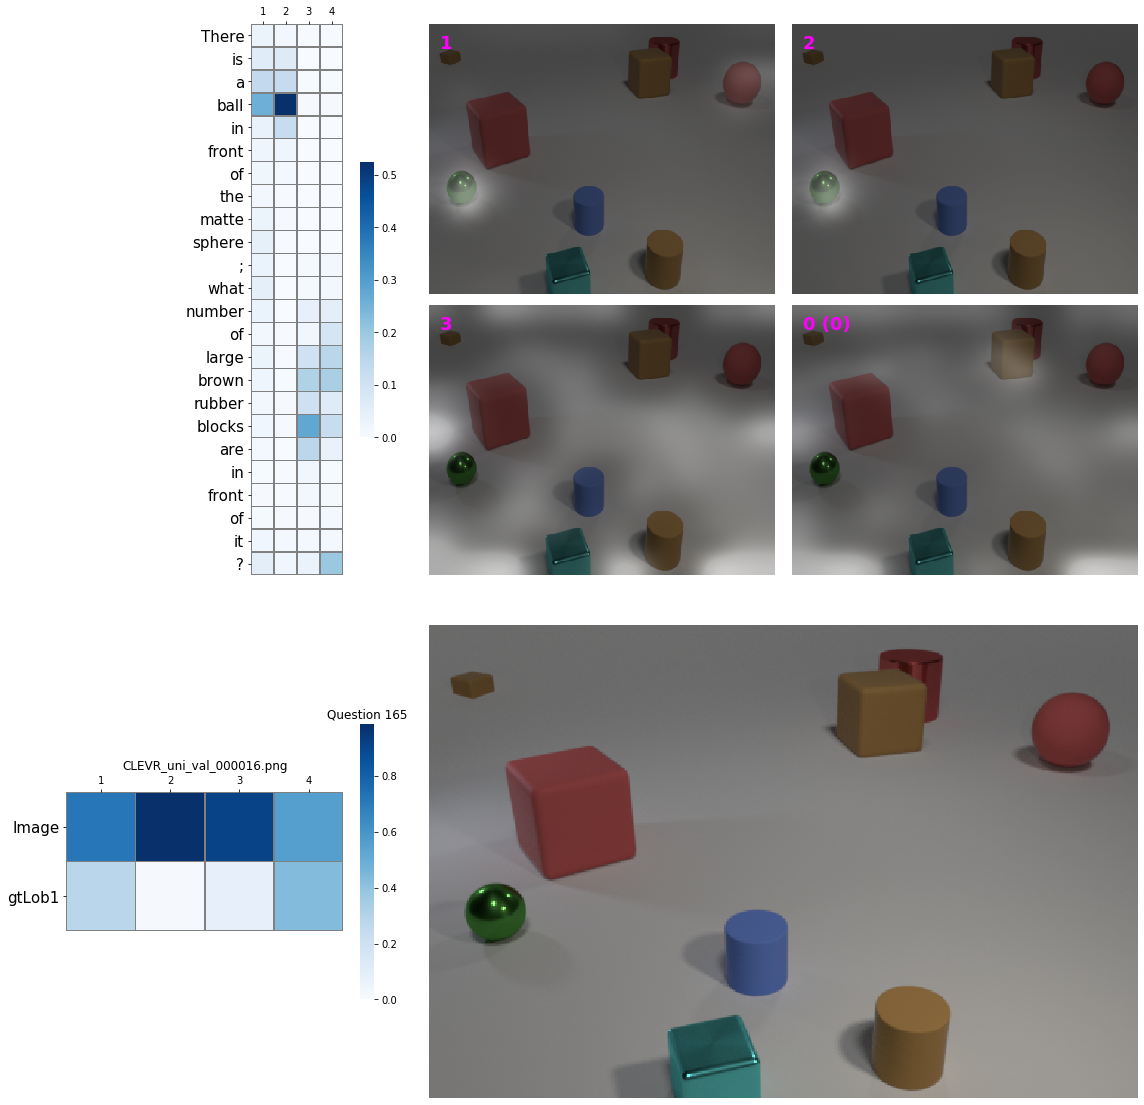

In [191]:
# q_index = 10
fig = show_and_tell(q_index)
q_index += 11

In [204]:
from tqdm.autonotebook import tqdm

def calc_accuracy_and_get_answer(model, loader):
    total_correct = 0
    total_samples = 0
    pbar = tqdm(loader, total=len(loader))
    
    all_predictions = []
    all_answers = []
    
    for data in pbar:
        image, question, question_len, answer = data['image'], data['question'], data['question_length'], data['answer']
        answer = answer.long()
        image = image.to(DEVICE)
        question = question.to(DEVICE)
        answer = answer.to(DEVICE).squeeze()

        with torch.no_grad():
            scores = model(image, question, question_len)

        correct = scores.detach().argmax(1) == answer
        total_correct += correct.sum().cpu().item()
        total_samples += answer.size(0)

        avg_acc = total_correct / total_samples

        pbar.set_postfix({
            'Acc': f'{avg_acc:.5f}',
        })
        
        all_predictions.append(scores.detach().argmax(1).cpu().numpy())
        all_answers.append(answer.cpu().numpy())
        
    return all_predictions, all_answers

In [205]:
loader = torch.utils.data.DataLoader(dataset=ds, batch_size=256, drop_last=False,
                shuffle=False, num_workers=1, collate_fn=collate_fn)

all_preds, all_ans = calc_accuracy_and_get_answer(model, loader)